In [2]:
#from v4_RGF_BBG.py import test_Gk_single
from FastRGF.solveRGF import MOMfastrecDOSfull
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.linalg import norm
from scipy.integrate import simpson, quad
from functools import partial
import mpmath
import pickle

%load_ext autoreload
%autoreload 2

### Import of functions from file without dask

In [2]:
epsA1 = 0 
deltaprime = 0.022
epsA2 = deltaprime
epsB1 = deltaprime
epsB2 = 0
gamma0 = 3.16
gamma1 = 0.381
gamma3 = 0.38
gamma4 = 0.14



def ret_H0(kx):
	Tx = np.zeros((8,8),dtype=np.cdouble)
	Tx[0,5] = -gamma3
	Tx[0,6] = -gamma0
	Tx[0,7] = gamma4
	Tx[2,5] = gamma4
	Tx[3,5] = -gamma0
	Tx = Tx * np.exp(-1j*kx)
	#P = Tx + Tx.conj().T

	#Horrible code ahead : please don't judge

	M = np.zeros((8,8),dtype=np.cdouble)
	M[0,0] = epsB2
	M[0,1] = -gamma3
	M[0,2] = -gamma0
	M[0,3] = gamma1
	M[1,1] = epsA1
	M[1,2] = gamma4
	M[1,3] = -gamma0
	M[1,4] = -gamma3
	M[1,6] = gamma4
	M[1,7] = -gamma0
	M[2,2] = epsA2
	M[2,3] = gamma1
	M[2,4] = -gamma0
	M[3,3] = epsB1
	M[3,4] = gamma4
	M[4,4] = epsB2
	M[4,5] = -gamma3
	M[4,6] = -gamma0
	M[4,7] = gamma4
	M[5,5] = epsA1
	M[5,6] = gamma4
	M[5,7] = -gamma0
	M[6,6] = epsA2
	M[6,7] = gamma1
	M[7,7] = epsB1
	M = M + Tx
	M = M + M.conj().T - np.diag(np.diag(M))

	return M 


def ret_Ty(kx):
	# non-hermitian : only couples along -ve y direction
	Ty = np.zeros((8,8),dtype = np.cdouble)
	Ty[0,2] = -gamma0
	Ty[0,3] = gamma4
	Ty[0,5] = -gamma3 * np.exp(-1j*kx)
	Ty[1,2] = gamma4
	Ty[1,3] = -gamma0
	Ty[1,4] = -gamma3
	Ty[6,4] = -gamma0
	Ty[6,5] = gamma4
	Ty[7,4] = gamma4
	Ty[7,5] = -gamma0

	return Ty


def generate_grid_with_peaks(a, b, peaks, peak_spacing=0.01, num_pp = 200, num_uniform=1000):
    # Sort the peaks list
    assert a < b , "a should be less than b" 
    peaks = sorted(peaks)
    
    # Generate grid around peaks
    peak_grid = np.concatenate([np.linspace(max(a, peak - peak_spacing), min(b, peak + peak_spacing), num = num_pp, dtype=np.double)
                                for peak in peaks])

    # Generate uniform grid for the remaining region
    # uniform_grid = np.linspace(max(a, min(peaks, default=a) + peak_spacing),
    #                            min(b, max(peaks, default=b) - peak_spacing), num=int((b - a) / uniform_spacing))
    uniform_grid = np.linspace(a,b,num=num_uniform,dtype=np.double)

    # Concatenate the peak and uniform grids
    grid = np.sort(np.concatenate([peak_grid, uniform_grid]))

    return grid


def test_Ginfkx():
	# omega = 1 - 1e-2
	omega = 2e-3 
	# omega = 0.000444967
	# omega = 0.000740532
	# omega = 2e-2
	omegavals = (omega,)
	# kxvals = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
	kxvals = np.linspace(-0.2,0.2,1000,dtype=np.double)
	# delta = min(1e-4,0.01*omega)
	# delta = 1e-4 if omega>1e-3 else 1e-6
	delta = 1e-6
	# delta = 0.01*omega
	RECURSIONS = 30
	dimH = 8
	num_pp = 2000
	start_time = time.perf_counter()
	kDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
					for omega in omegavals for kx in kxvals],dtype=np.longdouble).reshape((len(omegavals),len(kxvals),dimH,dimH))
	# peaks = find_peaks(kDOS[0,:,0,0],prominence=0.01*np.max(kDOS[0,:,0,0]))[0]
	peaks = find_peaks(kDOS[0,:,0,0],prominence=0.1)[0]
	print(f'Peaks found on sparse grid : {len(peaks)}')
	peakvals = [kxvals[peak] for peak in peaks]
	print("creating fine grid")
	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=1000,num_pp=num_pp)
	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)

	print('finding additional peaks')
	# new_peaks = find_peaks(fine_integrand,prominence=0.01*np.max(fine_integrand))[0]
	new_peaks = find_peaks(fine_integrand,prominence=0.1)[0]
	new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
	new_peakvals = sorted(new_peakvals)

	fig, ax = plt.subplots(1)
	ax.plot(kxvals, kDOS[0,:,0,0])
	ax.set_xlabel(r'$k_x$')
	ax.set_title(f'$\\omega$ = {omega:.3}, \\delta = {delta:.6}, RECURSIONS = {RECURSIONS}')
	# ax.vlines(kxvals[peaks], ls = '--', c = 'grey')
	for peak in new_peakvals:
		ax.axvline(peak,ls='--',c='gray')

	# ax.legend()
	# print('Started quad integrate without peaks')
	# start_time = time.perf_counter()
	# intval = quad(lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta,)[0,0], 
	# 					-np.pi,np.pi)[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	print(f'Total number of peaks found = {len(new_peakvals)}')

	# print('Started quad integrate WITH peaks')
	# start_time = time.perf_counter()
	# call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0]

	# start,stop = -np.pi,np.pi
	# ranges = []
	# eta = 0.5*delta
	# # eta = 1e-3
	# current = start
	# for peak in new_peakvals:
	# 	ranges += [(current, peak-eta)]
	# 	current = peak+eta
	# ranges += [(current, stop)]		
	# intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
	# for word in list(zip(ranges,intlist)):
	# 	print(word)
	# intval = np.sum(intlist)

	# # intval = quad(call_int, -np.pi,np.pi, points = [kxvals[peak] for peak in peaks])[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	# print('STARTED SIMPSON INTEGRATION')
	# start_time = time.perf_counter()
	# simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {simpson_intval:.8}')



	# for num_pp in [2000]: #checking convergence
	# 	print('Started simpson integrate WITH peaks')
	# 	peak_spacing = 0.01
	# 	print(f'num_pp = {num_pp}, peak_spacing = {peak_spacing:.4}')
	# 	start_time = time.perf_counter()
	# 	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,new_peakvals,peak_spacing=0.1,num_uniform=10000,num_pp=num_pp)
	# 	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)
	# 	simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# 	elapsed = time.perf_counter() - start_time
	# 	print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# 	print(f'intval = {simpson_intval:.8}')
	# print(type(fine_integrand[0]))
	ax.plot(adaptive_kxgrid,fine_integrand,'.',c='red')
	plt.show()
	print(adaptive_kxgrid[fine_integrand<0])
    
    
def helper_LDOS_mp(omega):
    RECURSIONS = 20
    delta = 1e-5 #if omega>1e-3 else 1e-6
    num_pp = 1000
    call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[1,1]
    
    kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
    # sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
    # 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
    sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
    peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
    peakvals = [kxgrid[peak] for peak in peaks] #peakvals
    peakvals = sorted(peakvals)

    if len(peakvals) > 20:
        return float('NaN')

    adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
    fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
    new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
    new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
    new_peakvals = sorted(new_peakvals)

    if len(new_peakvals) > 25:
        return float('NaN')

    start,stop = -np.pi,np.pi
    ranges = []
    # eta = 0.5*delta
    eta = 0.5*delta
    current = start
    for peak in new_peakvals:
        ranges += [(current, peak-eta)]
        current = peak+eta
    ranges += [(current, stop)]    
    intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
    LDOS = np.sum(intlist)
    print('done', omega)
    return LDOS


def helper_LDOS_mpmath_version(omega):
    RECURSIONS = 20
    delta = 1e-5 #if omega>1e-3 else 1e-6
    num_pp = 1000
    call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
    kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
    # sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
    # 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
    sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
    peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
    peakvals = [kxgrid[peak] for peak in peaks] #peakvals
    peakvals = sorted(peakvals)

    if len(peakvals) > 20:
        return float('NaN')

    adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
    fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
    new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
    new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
    new_peakvals = sorted(new_peakvals)

    if len(new_peakvals) > 25:
        return float('NaN')

    start,stop = -np.pi,np.pi
    ranges = []
    # eta = 0.5*delta
    eta = 0.5*delta
    current = start
    for peak in new_peakvals:
        ranges += [(current, peak-eta)]
        current = peak+eta
    ranges += [(current, stop)]    
    intlist = [float(mpmath.quad(call_int,[window[0],window[1]])) for window in ranges]
    LDOS = np.sum(intlist)
    print('done mpmath', omega, LDOS)
    return LDOS


def test_LDOS_mp():
    '''
    Use scipy.quad for this
    '''
    #RECURSIONS = 25
    #delta = 1e-3
    omegavals = np.logspace(np.log10(1e-6), np.log10(0.5e0), num = 150)

    
    
    LDOS = [helper_LDOS_mpmath_version(wi) for wi in omegavals]
    print(list(omegavals))
    print(list(LDOS))
    
    #savedict = {'omegavals' : omegavals,
    #			'LDOS' : LDOS,
    #			'INFO' : '[0,0] site of -1/pi Im G, delta = 1e-4 if omega>1e-3 else 1e-6, RECURSIONS = 25'
    #			}
    fig,ax = plt.subplots(1)
    ax.plot(omegavals, LDOS, '.-', label = 'quad LDOS')
    ax.axvline(1., ls='--', c='grey')
    ax.set_xlabel('omega')
    # ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
    plt.show()

### Test of DOS run on small scale set of omega

done 1e-06
done 7.196856730011514e-06
done 5.1794746792312125e-05
done 0.0003727593720314938
done 0.0026826957952797246
done 0.019306977288832496
done 0.1389495494373136
done 1.0


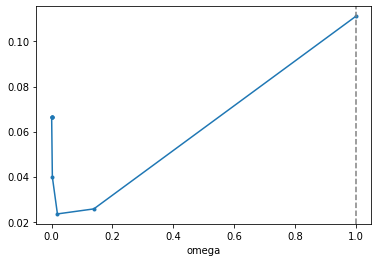

In [42]:
test_LDOS_mp()

done 1e-06
done 1.1544756045607413e-06
done 1.3328139215258865e-06
done 1.5387011578205702e-06
done 1.7763929494132119e-06
done 2.0508023242112562e-06
done 2.367601253078359e-06
done 2.733337888006407e-06
done 3.1555719107249703e-06
done 3.643030789369104e-06
done 4.205790172990282e-06
done 4.8554821526185805e-06
done 5.605535693578215e-06
done 6.471454208730524e-06
done 7.47113601001131e-06
done 8.625244261913331e-06
done 9.95763408375644e-06
done 1.1495845628839358e-05
done 1.3271673332291247e-05
done 1.5321823093829606e-05
done 1.7688670979221627e-05
done 2.042113912261293e-05
done 2.357570693439752e-05
done 2.7217578516035438e-05
done 3.14220304119794e-05
done 3.627596755639591e-05
done 4.187971957569592e-05
done 4.8349114575985866e-05
done 5.581787328008772e-05
done 6.444037300032412e-05
done 7.439483857766871e-05
done 8.588702624315285e-05
done 9.915447654598794e-05
done 0.00011447142425533328
done 0.00013215446672210486
done 0.00015256910786440423
done 0.00017613731303905086
don

<ipython-input-43-7e15895ed468>:230: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


done 0.020162689088087615
done 0.02327733267454021
done 0.026873112712001254
done 0.03102435304461659
done 0.03581685873728954
done 0.041349689644199016
done 0.047737207950385586
done 0.05511144200856322
done 0.06362481533105013
done 0.07345329714437963
done 0.08480003962773727
done 0.09789957701600682
done 0.1130226733617951
done 0.1304819191584296
done 0.15063819250467347
done 0.17390811836177025
done 0.20077268008372526
done 0.23178716121893903
done 0.26759262307765214
done 0.308929155303567
done 0.35665117333552393
done 0.4117450789538268
done 0.4753496489501284
done 0.5487795733494356
done 0.633552629713174
done 0.7314210552091641
done 0.8444077649010534
done 0.974848164879928
done 1.1254384245046818
done 1.299291205525931
done 1.5


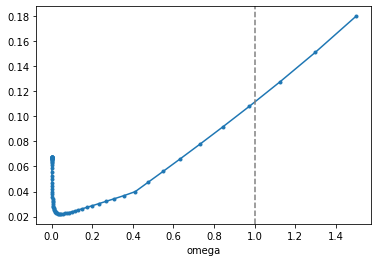

In [44]:
test_LDOS_mp()

In [10]:
kx =  0.00073387
omega = 2e-3
RECURSIONS = 30
delta = 1e-6
DOSkx = MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0]
print(DOSkx)

[[ 0.86780996+0.06587328j -1.1453415 -0.10994893j  0.16540162+0.00246276j
  -0.04971415+0.00115906j -0.86895758-0.06548117j  1.23118694+0.11439097j
  -0.17522283-0.00295996j  0.04863127-0.00126631j]
 [ 0.53615283-0.04608413j  5.19684303+0.00861432j  0.62624625-0.01493847j
   0.24742468-0.01992061j -0.49705442+0.04334108j -5.07715748-0.0104518j
  -0.64041716+0.01515681j -0.24952254+0.02047689j]
 [ 0.09093957-0.02007246j  0.99766211+0.02027283j  0.01531817+0.00179857j
  -0.0169172 -0.00350442j  0.22457703+0.01960119j -0.97502372-0.02091434j
  -0.01984496-0.00173088j -0.02060373+0.00357275j]
 [ 0.00588436+0.00474668j  0.09276541+0.01844144j -0.02232614+0.00179283j
  -0.01661581+0.00038618j  0.00591027-0.00466288j  0.22185142-0.01801992j
  -0.01565491-0.0018411j   0.0133737 -0.00039801j]
 [-0.86309603-0.06531026j  1.16436311+0.11204648j  0.14971212-0.00221631j
   0.06138381-0.00114935j  0.86935753+0.06492401j -1.21155696-0.11642995j
   0.17250193+0.00270677j -0.04708817+0.00125561j]
 [-0.4

### Test mpmath quadrature

In [53]:
omegavals = np.logspace(np.log10(1e-6), np.log10(0.25e0), num = 10)
LDOS_mpmath = [helper_LDOS_mpmath_version(wi) for wi in omegavals]
LDOS = [helper_LDOS_mp(wi) for wi in omegavals]
print('scipy', list(LDOS))
print('mpmath', list(LDOS_mpmath))

done mpmath 1e-06
done mpmath 3.9789740984925685e-06
done mpmath 1.5832234876474746e-05
done mpmath 6.299605249474357e-05
done mpmath 0.00025065966118386306
done mpmath 0.000997368299387514
done mpmath 0.003968502629920496
done mpmath 0.01579056917425329
done mpmath 0.06283026574480902
done mpmath 0.25
done 1e-06
done 3.9789740984925685e-06
done 1.5832234876474746e-05
done 6.299605249474357e-05
done 0.00025065966118386306
done 0.000997368299387514
done 0.003968502629920496
done 0.01579056917425329


<ipython-input-52-f64f1eed3a43>:230: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


done 0.06283026574480902
done 0.25
scipy [0.10126218221023715, 0.10083875986750816, 0.09916467956052166, 0.09324246305028742, 0.0839835706100283, 0.05841263631256928, 0.032606221723735646, 0.02418670725349543, 0.02247634951652512, 0.03143527163361074]
mpmath [0.1012621821654499, 0.10083875987001158, 0.09916469217918658, 0.0932424630358833, 0.08398357062668439, 0.058412636586427674, 0.03260622490061041, 0.024186827725321516, 0.022759739103880208, 0.031606085110435195]


### Data generation with mpmath 1e3

done mpmath 1e-06 0.10632949648981117
done mpmath 1.0920640755757991e-06 0.1062486624307076
done mpmath 1.192603945163225e-06 0.10616061854850184
done mpmath 1.3023999249027283e-06 0.106064766785185
done mpmath 1.4223041700188884e-06 0.10596046170774401
done mpmath 1.5532472886192849e-06 0.10584692881148587
done mpmath 1.6962455643866359e-06 0.10572337904530722
done mpmath 1.8524088442214412e-06 0.10558914842883776
done mpmath 2.022949152053123e-06 0.10544347262298337
done mpmath 2.2091900956737407e-06 0.10528552791780574
done mpmath 2.412577139603155e-06 0.10511446537858064
done mpmath 2.6346888237160255e-06 0.10492938916245192
done mpmath 2.877249014701331e-06 0.1047292535584209
done mpmath 3.1421402854411884e-06 0.10451339973359042
done mpmath 3.431418526149816e-06 0.10428100089868979
done mpmath 3.7473289006734703e-06 0.10403107984654603
done mpmath 4.092323271792449e-06 0.1037634594025221
done mpmath 4.469079230767351e-06 0.10347745826244335
done mpmath 4.880520878822952e-06 0.103

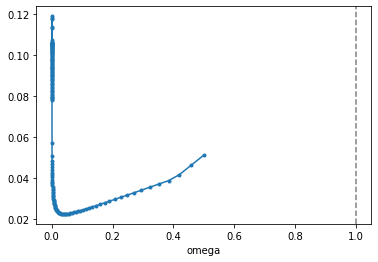

In [3]:
test_LDOS_mp()

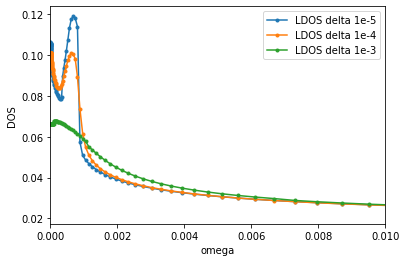

In [3]:
omegavals = [1e-06, 1.0920640755757991e-06, 1.192603945163225e-06, 1.3023999249027283e-06, 1.4223041700188884e-06, 1.5532472886192849e-06, 1.6962455643866359e-06, 1.8524088442214412e-06, 2.022949152053123e-06, 2.2091900956737407e-06, 2.412577139603155e-06, 2.6346888237160255e-06, 2.877249014701331e-06, 3.1421402854411884e-06, 3.431418526149816e-06, 3.7473289006734703e-06, 4.092323271792449e-06, 4.469079230767351e-06, 4.880520878822952e-06, 5.329841521860173e-06, 5.820528454535741e-06, 6.356390026065222e-06, 6.941585197814148e-06, 7.580655822081558e-06, 8.278561892599797e-06, 9.040720040339037e-06, 9.873045573392452e-06, 1.0781998387224565e-05, 1.1774633101604153e-05, 1.2858653813347544e-05, 1.404247388982264e-05, 1.5335281267286458e-05, 1.6747109760854056e-05, 1.828891693955353e-05, 1.99726691708761e-05, 2.1811434494874072e-05, 2.3819484048626753e-05, 2.601240282825607e-05, 2.840721064814477e-05, 3.102249423615328e-05, 3.3878551490060294e-05, 3.699754901483981e-05, 4.040369416346136e-05, 4.412342291646774e-05, 4.818560505851238e-05, 5.2621768244284875e-05, 5.746634269285903e-05, 6.275692840959904e-05, 6.853458700960553e-05, 7.484416040761405e-05, 8.173461884778787e-05, 8.925944097454976e-05, 9.747702889428429e-05, 0.00010645116144931205, 0.00011625148922211323, 0.00012695407511165708, 0.00013864198467739236, 0.0001514059308327106, 0.00016534497789151767, 0.0001805673104322012, 0.00019719107294635018, 0.0002153452867889559, 0.00023517085154678674, 0.00025682163859681514, 0.00028046568534209295, 0.00030628649939384574, 0.0003344844828218877, 0.00036527848752733444, 0.0003989075138092646, 0.0004356325653083549, 0.0004757386747241826, 0.0005195371160283208, 0.000567367820342785, 0.0006196020142340996, 0.0006766451008994651, 0.0007389398066066685, 0.0008069696168080712, 0.0008812625285972634, 0.0009623951486321617, 0.0010509971683296167, 0.0011477562510646654, 0.0012534233693052787, 0.0013688186331054727, 0.0014948376551932572, 0.0016324585020545215, 0.0017827492849620248, 0.0019468764498654708, 0.002126113830482629, 0.002321852534854936, 0.002535611742099682, 0.002769050493155231, 0.0030239805670302785, 0.0033023805424931053, 0.0036064111543372395, 0.003938432063407549, 0.004301020170543251, 0.004696989616577183, 0.005129413623616494, 0.005601648347120657, 0.006117358923899024, 0.006680547918193153, 0.007295586386621443, 0.007967247803089132, 0.00870074510696385, 0.009501771162057134, 0.010376542940424713, 0.011331849773907499, 0.012375106047906148, 0.013514408746359109, 0.014758600294546155, 0.016117337187456265, 0.01760116493636288, 0.019221599915286297, 0.02099121874257499, 0.022923755891319546, 0.025034210286179165, 0.027338961713946466, 0.029855897951343118, 0.03260455359671892, 0.03560626168316244, 0.0388843192497328, 0.0424641681558537, 0.046373592542217665, 0.05064293447074571, 0.055305329417240805, 0.06039696344445413, 0.06595735405155313, 0.07202965687973507, 0.07866100065440988, 0.08590285296352547, 0.09381141971093625, 0.10244808134507691, 0.11187986924862568, 0.12217998598654195, 0.13342837345025704, 0.14571233330753747, 0.15912720457348864, 0.17377710356150797, 0.18977573195713812, 0.20724725928649268, 0.2263272866283216, 0.24716389904933747, 0.2699188149310249, 0.2947686411081649, 0.32190624356052266, 0.3515422442960003, 0.3839066560429533, 0.4192506674389441, 0.4578485925712473, 0.5]
LDOS5 = [0.10632949648981117, 0.1062486624307076, 0.10616061854850184, 0.106064766785185, 0.10596046170774401, 0.10584692881148587, 0.10572337904530722, 0.10558914842883776, 0.10544347262298337, 0.10528552791780574, 0.10511446537858064, 0.10492938916245192, 0.1047292535584209, 0.10451339973359042, 0.10428100089868979, 0.10403107984654603, 0.1037634594025221, 0.10347745826244335, 0.10317285872617511, 0.10284964052405703, 0.10250779154601519, 0.10214809435673429, 0.10177086204789668, 0.10137665122155456, 0.10096761896055416, 0.10054520657382361, 0.10010997385611174, 0.09966428898483498, 0.09920999969933303, 0.0987483272830655, 0.09828123516248126, 0.09780963405831757, 0.09733429042373595, 0.09685595381571978, 0.09637498952764326, 0.09589237822179668, 0.09540531220015039, 0.09491632407222299, 0.09442349981470073, 0.09392542605246557, 0.09342224326430273, 0.09291293739725832, 0.09239633972356402, 0.09187143432968156, 0.09133713509265975, 0.09079312119829079, 0.09023792638284982, 0.08967077183167155, 0.08909177708575972, 0.08849999251991447, 0.0878949156177548, 0.08727657238147671, 0.08664480861073129, 0.08599973980407662, 0.08534158566724284, 0.08467093013441133, 0.08398901587009446, 0.08329545899585027, 0.08259395185521384, 0.0819157361057004, 0.0812052429586806, 0.08049889043497058, 0.07980786891989973, 0.07915479658854101, 0.07859490801250693, 0.07831594934261721, 0.07965701935414611, 0.08975111049122028, 0.09379711455480759, 0.09755960889355678, 0.10213678503163279, 0.1075999424626809, 0.11330859128995385, 0.11758770707860537, 0.11912446386835981, 0.1182482053387827, 0.11404566372757872, 0.05735651814530946, 0.05083526720279812, 0.04856372299374136, 0.04682484295060092, 0.04530419372939849, 0.04392127375632674, 0.042643387321062064, 0.04145241816534055, 0.04033594246741309, 0.039284826327654815, 0.03829153077585475, 0.03735054273986564, 0.03645577059407025, 0.035602592363344156, 0.03478828908426937, 0.03400842489048404, 0.0332603415115036, 0.032541268318279866, 0.03185019708937065, 0.031184437901909935, 0.03054090981119262, 0.029921441672397867, 0.029320875111239358, 0.02874285097833794, 0.0281855254342877, 0.02764931788938892, 0.027134956902355126, 0.026642368080090177, 0.026170510930830965, 0.025724267873235597, 0.025302893178773083, 0.02490720348147947, 0.024538904553694896, 0.024200271296129644, 0.02389149007819407, 0.023610537218641123, 0.023357065718820375, 0.023140326222889168, 0.022949392281570096, 0.022789634112691484, 0.022666990013414177, 0.022565128693034692, 0.022508042237533412, 0.022475127431627082, 0.02247550541599205, 0.02250337728297888, 0.022570030563234506, 0.022672515449954158, 0.02280821706266931, 0.02298556336487552, 0.023189788171408893, 0.023448187965615763, 0.02373048244770408, 0.02406473725957695, 0.0244503441654465, 0.024872559969170094, 0.025355780312747864, 0.025894136683889613, 0.02648248447393206, 0.027146274295676308, 0.02787626550638196, 0.028683756026201143, 0.029559151659947963, 0.03054001174473865, 0.03160538398861842, 0.0327846563913046, 0.03407903852806024, 0.035492027569897534, 0.03703567484893591, 0.03873505176475784, 0.041637258733965135, 0.04621384605105409, 0.051238491035900655]

LDOS4 = [0.1012621821654499, 0.10124910411790883, 0.10123482214811746, 0.10121922543296115, 0.10120219183834131, 0.1011835905597493, 0.1011632625094995, 0.1011410287677311, 0.10111679200658065, 0.10109031815800529, 0.10106140395174369, 0.10102983375612745, 0.10099535803616136, 0.10095768974466449, 0.10091657445657358, 0.10087167635553797, 0.10082265474095364, 0.10076912427121136, 0.10071065491681254, 0.10064682342763687, 0.10057715107138872, 0.1005010455483709, 0.10041799340724337, 0.1003273528446699, 0.10022842061876366, 0.10012050277591346, 0.10000272234256247, 0.09987429961152411, 0.09973427689329623, 0.09958159602468679, 0.09941529230821207, 0.09923419417930911, 0.09903704787507832, 0.09882260908013635, 0.0985895660925356, 0.09833649362440808, 0.09806203357185202, 0.09776464222697917, 0.09744294173732107, 0.09709553008798762, 0.09672102194896387, 0.09631825684662036, 0.09588613460657097, 0.09542384432304532, 0.09493084768641816, 0.09440700879776953, 0.09385258361159576, 0.09326834201909234, 0.09265560723421416, 0.09201635149492808, 0.09135313645572365, 0.09066926925346556, 0.08996877640250182, 0.08925630811067876, 0.08853752002111218, 0.0878188290668289, 0.08710804012161212, 0.08641448623713546, 0.08574984676632921, 0.08512929200322607, 0.08457343940675574, 0.08411126987584303, 0.08410252938633059, 0.08397241526088198, 0.08413649784971494, 0.08472230188067556, 0.08585953890418722, 0.08758167104962686, 0.0897595050466722, 0.09222339727890033, 0.09485710083734827, 0.09750153129857603, 0.09955245316238134, 0.10089650514767295, 0.10042415983026706, 0.09837015294489296, 0.08946687971020571, 0.07357719609670627, 0.06158806325971791, 0.05485451950116224, 0.050946567146644514, 0.04821267399558555, 0.04607848544497766, 0.044297588975291805, 0.0427495147645741, 0.04136828439496037, 0.04011417830657833, 0.03896140460902965, 0.03789204217144157, 0.036893071633478706, 0.03595457100585452, 0.035068742623828225, 0.03422933527061377, 0.03343129289632121, 0.03267036989857611, 0.0319429656675001, 0.031246348312593833, 0.030577845040657678, 0.029935726905821646, 0.02931840811044609, 0.028724901771489345, 0.028154591910954766, 0.027606969412028042, 0.02708239733241574, 0.026581092003221597, 0.026103847960225822, 0.025651599879309803, 0.025225046433418347, 0.024825027869233962, 0.02445292922952735, 0.0241094836431194, 0.0237953983409843, 0.023511259362016174, 0.023257566268530035, 0.023034921755196877, 0.022843151833741682, 0.0226825986402972, 0.022553120316827078, 0.022455943876488277, 0.02239085684023185, 0.022357044038040473, 0.02235516815274474, 0.022386896687808855, 0.0224523087916484, 0.022552938612312654, 0.02268787945589467, 0.02285776895439167, 0.02306831811531343, 0.023315202887942366, 0.023604741051859893, 0.023937442981996265, 0.02431532631915847, 0.024742867916550126, 0.025222107009221218, 0.025756000952601905, 0.026349782928255197, 0.027008227249589255, 0.027736573594703034, 0.028537271576523277, 0.029419144600147083, 0.030393928467522726, 0.0314588343647491, 0.03263246278062185, 0.0339189184212912, 0.035331592801061074, 0.0368791776665768, 0.03857976617635602, 0.04146114400490681, 0.04600487437667386, 0.051007062929792034]
LDOS3 = [0.06643359005464965, 0.06643344972268826, 0.06643328872361876, 0.06643312070992122, 0.06643293701071232, 0.06643273614407633, 0.06643251647692797, 0.06643227622104973, 0.06643201340977076, 0.06643172588306034, 0.0664314031039118, 0.06643105813214807, 0.0664306805188526, 0.06643026708754281, 0.06642981433804916, 0.06642931007660567, 0.06642876574393329, 0.06642816916932498, 0.06642750644899392, 0.0664267878611834, 0.06642599176701874, 0.06642512503617627, 0.06642416534030562, 0.06642311808359655, 0.06642195888061478, 0.06642069110984374, 0.0664192863232652, 0.06641773916649127, 0.06641603288353196, 0.06641415010781705, 0.0664120699645849, 0.06640977029580411, 0.06640722475661073, 0.06640439709683596, 0.06640126844204175, 0.06639778650547727, 0.06639392281625835, 0.06638961310007128, 0.06638480138432978, 0.06637943716458931, 0.06637343970344037, 0.06636671492396634, 0.06635917296381352, 0.06635069941970059, 0.06634115468531356, 0.06633039466002542, 0.06631824239988376, 0.06630448406080555, 0.06628888847671251, 0.06627116730568151, 0.06625100704088262, 0.06622802199324404, 0.06620176328652048, 0.06786787674450773, 0.06783492246504214, 0.06779693717496922, 0.06775307412619344, 0.06770234387399214, 0.06764357116063839, 0.06757537862367559, 0.06749613774187246, 0.06740393666713568, 0.06729650201163237, 0.06717116211057869, 0.06702509716846136, 0.06685472245621417, 0.0666557226990713, 0.0664230103880159, 0.06615058157596371, 0.06583137061721045, 0.06545710524241251, 0.0650181852541423, 0.0645036267869313, 0.06390114076415962, 0.06319744643275557, 0.06237894957570603, 0.06143291897478659, 0.06034923856701029, 0.059122656878826146, 0.057755187715999565, 0.055076862092914514, 0.0534951979653927, 0.05183929588754742, 0.05014341173552098, 0.04844210015526349, 0.04676615081173046, 0.045139846278385715, 0.04357981831055107, 0.04209499781956525, 0.04068767897159649, 0.03935761426507298, 0.03810410525512802, 0.03692503685886629, 0.03581694295196158, 0.03477556719249603, 0.03379633664912885, 0.03287462651949755, 0.03200606166464843, 0.031186531451605992, 0.030408555103675988, 0.02967235302216216, 0.02876122275945258, 0.028113198062981397, 0.027500513746463857, 0.02692201484687158, 0.02637693569989171, 0.025864757878928488, 0.025385251983109047, 0.02493839851321122, 0.024524311023423034, 0.0241429766123732, 0.02379466006558246, 0.023479514503150577, 0.023197641162521578, 0.02294897211771628, 0.02273371845573034, 0.022551847478841355, 0.022403070963494687, 0.022287887879557638, 0.022205921469894172, 0.022157355469297556, 0.022142690176242374, 0.022161741229541378, 0.022215549499919884, 0.022304694034693262, 0.022429701132448774, 0.02259167477064504, 0.022791892754730977, 0.023031803965136207, 0.02331342973972711, 0.023638632822084327, 0.024009794023181662, 0.024429979316525543, 0.02490183221323018, 0.025429385006494516, 0.02601612768023224, 0.02666777279141673, 0.027386786589931236, 0.028182484574868792, 0.029057848050210618, 0.030022056289474783, 0.031082721637163732, 0.03224798610184345, 0.03352871892344231, 0.03493491142390077, 0.03648188053118305, 0.03818905872877551, 0.04095519616273511, 0.04538941971653353, 0.050249249372056506]

omegavals7e6 = np.logspace(np.log10(1e-6), np.log10(1.0e0), num = 500)
LDOS7e6 = [0.10577438209637677, 0.10574234311489886, 0.10570944863279556, 0.10567567538746751, 0.10564100364691684, 0.1056054115873929, 0.10556887674920713, 0.10553137757960836, 0.10549289231620539, 0.1054533978503324, 0.10541286673963637, 0.1053712800320647, 0.10532858721338977, 0.10528467147646733, 0.10523968335865903, 0.10519354214151268, 0.1051462234605389, 0.10509770240969439, 0.10504792589702731, 0.10499690001560254, 0.10494459803519555, 0.10489099622505718, 0.10483607291048959, 0.10477980059268853, 0.10472216009783439, 0.10466312672821496, 0.10460267355669225, 0.10454077908791815, 0.10447742409841017, 0.10441258431844452, 0.1043462409449007, 0.1042783627941061, 0.1042089334631449, 0.10413794658713037, 0.10406538107339748, 0.10399122483817604, 0.1039154729619795, 0.1038381055702589, 0.10375910989188736, 0.1036784624444372, 0.10359613692099848, 0.10351216775457646, 0.10342655132342432, 0.10333928874155088, 0.10325027893516725, 0.10315958784161945, 0.10306724590659479, 0.10297326938470343, 0.10287767920704978, 0.102780487454557, 0.1026813843082147, 0.10258064859050875, 0.10247823562278688, 0.10237423531941195, 0.10226871638696497, 0.10216157365970725, 0.1020528812033696, 0.10194276251733769, 0.10183126095988301, 0.10171840173440926, 0.10160425169366435, 0.10148885602487205, 0.10137226779602113, 0.10125444477243646, 0.10113541730439027, 0.10101534985032291, 0.10089429657887658, 0.10077226317977031, 0.10064913366238135, 0.10052514073333405, 0.10040029850118584, 0.10027458962041187, 0.10014822347488707, 0.10002127279141677, 0.09989383385506943, 0.09976561360142963, 0.09963702367244436, 0.09950812016997679, 0.09937899153326478, 0.09924962004771683, 0.09911884640976994, 0.098987848412526, 0.09885665609113838, 0.09872538675554389, 0.09859421439976111, 0.09846296821005866, 0.09833167621304538, 0.09820030632325845, 0.0980689313551111, 0.09793704852529143, 0.097805091897862, 0.09767334749309842, 0.09754172375752468, 0.09741029984753351, 0.09727851110342382, 0.09714658834138779, 0.0970149002833696, 0.09688346139069279, 0.0967525559295174, 0.09662158234102981, 0.09648919845419018, 0.09635694605089593, 0.09622502889707353, 0.09609333492377059, 0.09596162848249669, 0.09583000538045082, 0.09569765289046198, 0.09556536563111398, 0.09543344864218663, 0.09530016697508771, 0.09516696326426015, 0.09503424663840729, 0.09490167251400801, 0.09476870568080378, 0.09463445931023852, 0.0944984845055793, 0.0943625387749212, 0.09422705515674897, 0.09409084203306092, 0.09395445667234868, 0.09381818405433338, 0.09368057330604139, 0.09354274654829989, 0.09340244875322003, 0.09326238630060707, 0.09312144151309744, 0.09297954710314635, 0.09283701951971937, 0.09269382982355173, 0.0925520383883061, 0.09240612071687991, 0.09225896133706533, 0.092111602363062, 0.0919640313934284, 0.09181434727603267, 0.09166494490313956, 0.09151451170684621, 0.09136003323828851, 0.09120602519971252, 0.09105081481525343, 0.09089500260857374, 0.09073745185783677, 0.09057788185046668, 0.09041793007618032, 0.09025742049665421, 0.09009328425342393, 0.089929161022598, 0.08976354588543801, 0.08959760042719073, 0.08942801712817865, 0.08925715183385181, 0.08908637670488505, 0.08891385204378593, 0.08873810796229462, 0.08856210843767448, 0.08838564291408722, 0.08820474279977372, 0.08802443324140136, 0.0878425687478127, 0.08765843940800631, 0.0874725964206354, 0.08728551158681998, 0.08709679803111647, 0.08690720419044122, 0.0867148692763286, 0.086522160027554, 0.08632689839514485, 0.08613072664041471, 0.08593399461530761, 0.08573288236987865, 0.08553334631711322, 0.0853295571851042, 0.08512647800189303, 0.08492013757817427, 0.08471307133082859, 0.08450460783002578, 0.08429488532256264, 0.08408368832342746, 0.08387092709181207, 0.08365739855077423, 0.08344219675556837, 0.08322615854952503, 0.08300805528921916, 0.08278936737178383, 0.0825704156902458, 0.0823490833943255, 0.08214826749816972, 0.08192496523099137, 0.08170221332286903, 0.08147794259176626, 0.08125295013763427, 0.08102792556586971, 0.08080233155258544, 0.08057721306411655, 0.08035215141282555, 0.08012766596917402, 0.07990473806588415, 0.07968176323452865, 0.07946197428501861, 0.07924426265112189, 0.07902985553778241, 0.07882079364991998, 0.07861826189398921, 0.07842528135053968, 0.07824615879606849, 0.07808630910319656, 0.07795873247799812, 0.07787757020833237, 0.07788933272624357, 0.07808869537348632, 0.07879925610365254, 0.08149109530116512, 0.087382299985164, 0.09006186900343631, 0.09142888997520003, 0.09258265924641274, 0.09373301782573082, 0.09483880985735597, 0.09595235430699059, 0.09718403307322612, 0.09849402476078618, 0.09989365338067936, 0.10139060051622195, 0.10298758192101105, 0.10468346242268017, 0.10646861068365493, 0.10832047688670474, 0.11020765376667034, 0.11207708300639924, 0.11387113675435231, 0.11551756632528197, 0.11695291480600144, 0.11812554580588282, 0.11900624237830329, 0.11959018505884131, 0.11989110815977544, 0.11993281917307315, 0.1197413940988674, 0.1194648112820009, 0.11886609466284932, 0.11803766877240629, 0.11694742332810276, 0.11502860610292935, 0.10975838358163503, 0.06823571368164444, 0.055192024083607405, 0.05264776849360632, 0.05136177537984226, 0.05046617694318223, 0.04973248602697872, 0.04908780047548992, 0.04849816041501546, 0.04794587977285827, 0.04742110745942411, 0.04691678807333444, 0.046430792200268384, 0.04596007286017605, 0.04550275870975721, 0.04505846665157953, 0.0446243469677788, 0.04420093772639862, 0.04378755062507516, 0.043383387427144884, 0.042988230105915806, 0.04260152405560399, 0.042222306692037255, 0.04185134390347544, 0.041488091111401615, 0.04113119690250772, 0.040780980717995054, 0.040437809460026564, 0.04010065041910867, 0.03976957365109218, 0.03944457156863131, 0.0391249791112279, 0.03881157978931857, 0.03850271050439139, 0.038199298654641285, 0.037900644872060706, 0.03760708644969379, 0.03731872265531272, 0.03703326767740641, 0.036753085990657255, 0.03647693064459982, 0.036205531258153796, 0.035937760579162, 0.035673315332739874, 0.03541355025700479, 0.03515686897054464, 0.03490311274208316, 0.03465458318193144, 0.03440767038612862, 0.03416509873259847, 0.03392455334329752, 0.033687277740737674, 0.033453668735325695, 0.033222585710355516, 0.032995761512441664, 0.03277057127996315, 0.03254748653108284, 0.03232827446551218, 0.032110253528226565, 0.03189514633766297, 0.0316825456549544, 0.03147322950646077, 0.03126543806473552, 0.03106045754010047, 0.03085780674215492, 0.03065674829133569, 0.030458889167077004, 0.03026202628390624, 0.030067822961999512, 0.02987621231609503, 0.029685946726356893, 0.029498943169562253, 0.029312365666282796, 0.029129914625043274, 0.02894881030912284, 0.028769589302219213, 0.028590771286443484, 0.028415486670499028, 0.028243434657484762, 0.02807281991260738, 0.027900679277669992, 0.027735202492774905, 0.02756837307845139, 0.02740589337989562, 0.02724560095033847, 0.027085583533956802, 0.02692857639913541, 0.026776952642991108, 0.026621910664527744, 0.026472116388923238, 0.026327421007917427, 0.02617932209564919, 0.026036240545053428, 0.02589927195799261, 0.02576252329878534, 0.02562416730884738, 0.025490175515389034, 0.025358841675311494, 0.025233447494744387, 0.02510885609459379, 0.02498674561137594, 0.024862553737933175, 0.024744799496526297, 0.02462933275020991, 0.02451875370030868, 0.02441279502675761, 0.024304575951682797, 0.02420530493765015, 0.024101621288526342, 0.024000232427687715, 0.023905886593524675, 0.023816314669877686, 0.023731346847866142, 0.02364254714766687, 0.02356323067745724, 0.02347715195563505, 0.023398798280386664, 0.02333307328048416, 0.023256236951647493, 0.023192910322032575, 0.023125641597802712, 0.02305957538684925, 0.023001756584599416, 0.02294562599867006, 0.022900423948214597, 0.022844255232107008, 0.022797993139251047, 0.022761358569269686, 0.022717850145063456, 0.022684850639633897, 0.022649095005492732, 0.022612003074795946, 0.02259152133649407, 0.022565500914752526, 0.02254042842198402, 0.022525991792065363, 0.02250469445010146, 0.022493200308922864, 0.022490866977616066, 0.022479433678752016, 0.022478121196069616, 0.022485621461217797, 0.022479589677932038, 0.0224946535962118, 0.02250373205633911, 0.02251282890229866, 0.02252893099122055, 0.022553922554173263, 0.02258325164054082, 0.022606618758829446, 0.022638088804890974, 0.022673548591724275, 0.02270525385495888, 0.02274522935366039, 0.022799234460112734, 0.022846875268170884, 0.022891439400396587, 0.022945550284327505, 0.02301244357260672, 0.023064965581132798, 0.0231413948906094, 0.023203850744860845, 0.023284924319588465, 0.02336509965510777, 0.023446286890654207, 0.0235263920111829, 0.023613209872494823, 0.023707093453509475, 0.023818640114038985, 0.023919971728387748, 0.024025508594188456, 0.02412965120562236, 0.02425452027981645, 0.024373327502934635, 0.024492167696669634, 0.024634744056568323, 0.024760775045027966, 0.024897733550589503, 0.025059271401603373, 0.025196370186063265, 0.025351849407118043, 0.025522912668028534, 0.025692038197500763, 0.02586370126115099, 0.026038243312610787, 0.02623481164911459, 0.026417582864405754, 0.026608449422582003, 0.02680999840935189, 0.0270259152231767, 0.027241584086911033, 0.027474539616969947, 0.027707671227796434, 0.027936863749826586, 0.028181749149606288, 0.02843856394176136, 0.02870132205653606, 0.02897728635333312, 0.02924388238921185, 0.029537826455947002, 0.029827584013655938, 0.030134677696851152, 0.030446044735271106, 0.030769594523454923, 0.031107169294501177, 0.031444674948522974, 0.03179785165259917, 0.032152995566406446, 0.032523846787353754, 0.032906633790235736, 0.03331887734250154, 0.03371476529219929, 0.03413587787744716, 0.034562922771690076, 0.03501878798092506, 0.0354740932751986, 0.035943544848748475, 0.03643659162259064, 0.036937038564351245, 0.03745262850754255, 0.0379767951650509, 0.038524920255616525, 0.039090320504950954, 0.039662968205160784, 0.04027305671718494, 0.0422048628860939, 0.04361270284450692, 0.045072208893401314, 0.046561050441324, 0.04810194496011053, 0.04967522852759898, 0.051313696142591764, 0.05299423214862529, 0.05473797420704554, 0.05651740626496657, 0.05833874428179687, 0.06023002025710423, 0.06216888034931952, 0.0641628593138773, 0.06624977084990542, 0.06837040140154173, 0.07054989814037681, 0.07282436885711559, 0.0751469750607163, 0.07753228195756047, 0.08000641219903196, 0.08256409027894805, 0.08519040352782474, 0.0879062615524467, 0.09071651142865647, 0.09358543917920514, 0.09658521179373439, 0.09965764190286724, 0.10283531680458693, 0.10612053172911169, 0.1095177558647377, 0.11301672530032236]

fig,ax = plt.subplots(1)
ax.plot(omegavals, LDOS5, '.-', label = 'LDOS delta 1e-5')
ax.plot(omegavals, LDOS4, '.-', label = 'LDOS delta 1e-4')
ax.plot(omegavals, LDOS3, '.-', label = 'LDOS delta 1e-3')

#ax.plot(omegavals7e6, LDOS7e6, '.-', color='red', label = 'LDOS delta 7e-6')
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(0.0, 0.01)
ax.set_ylabel('DOS')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

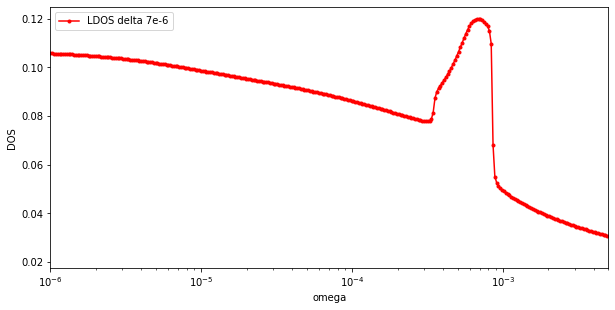

In [21]:
omegavals7e6 = np.logspace(np.log10(1e-6), np.log10(1.0e0), num = 500)
LDOS7e6 = [0.10577438209637677, 0.10574234311489886, 0.10570944863279556, 0.10567567538746751, 0.10564100364691684, 0.1056054115873929, 0.10556887674920713, 0.10553137757960836, 0.10549289231620539, 0.1054533978503324, 0.10541286673963637, 0.1053712800320647, 0.10532858721338977, 0.10528467147646733, 0.10523968335865903, 0.10519354214151268, 0.1051462234605389, 0.10509770240969439, 0.10504792589702731, 0.10499690001560254, 0.10494459803519555, 0.10489099622505718, 0.10483607291048959, 0.10477980059268853, 0.10472216009783439, 0.10466312672821496, 0.10460267355669225, 0.10454077908791815, 0.10447742409841017, 0.10441258431844452, 0.1043462409449007, 0.1042783627941061, 0.1042089334631449, 0.10413794658713037, 0.10406538107339748, 0.10399122483817604, 0.1039154729619795, 0.1038381055702589, 0.10375910989188736, 0.1036784624444372, 0.10359613692099848, 0.10351216775457646, 0.10342655132342432, 0.10333928874155088, 0.10325027893516725, 0.10315958784161945, 0.10306724590659479, 0.10297326938470343, 0.10287767920704978, 0.102780487454557, 0.1026813843082147, 0.10258064859050875, 0.10247823562278688, 0.10237423531941195, 0.10226871638696497, 0.10216157365970725, 0.1020528812033696, 0.10194276251733769, 0.10183126095988301, 0.10171840173440926, 0.10160425169366435, 0.10148885602487205, 0.10137226779602113, 0.10125444477243646, 0.10113541730439027, 0.10101534985032291, 0.10089429657887658, 0.10077226317977031, 0.10064913366238135, 0.10052514073333405, 0.10040029850118584, 0.10027458962041187, 0.10014822347488707, 0.10002127279141677, 0.09989383385506943, 0.09976561360142963, 0.09963702367244436, 0.09950812016997679, 0.09937899153326478, 0.09924962004771683, 0.09911884640976994, 0.098987848412526, 0.09885665609113838, 0.09872538675554389, 0.09859421439976111, 0.09846296821005866, 0.09833167621304538, 0.09820030632325845, 0.0980689313551111, 0.09793704852529143, 0.097805091897862, 0.09767334749309842, 0.09754172375752468, 0.09741029984753351, 0.09727851110342382, 0.09714658834138779, 0.0970149002833696, 0.09688346139069279, 0.0967525559295174, 0.09662158234102981, 0.09648919845419018, 0.09635694605089593, 0.09622502889707353, 0.09609333492377059, 0.09596162848249669, 0.09583000538045082, 0.09569765289046198, 0.09556536563111398, 0.09543344864218663, 0.09530016697508771, 0.09516696326426015, 0.09503424663840729, 0.09490167251400801, 0.09476870568080378, 0.09463445931023852, 0.0944984845055793, 0.0943625387749212, 0.09422705515674897, 0.09409084203306092, 0.09395445667234868, 0.09381818405433338, 0.09368057330604139, 0.09354274654829989, 0.09340244875322003, 0.09326238630060707, 0.09312144151309744, 0.09297954710314635, 0.09283701951971937, 0.09269382982355173, 0.0925520383883061, 0.09240612071687991, 0.09225896133706533, 0.092111602363062, 0.0919640313934284, 0.09181434727603267, 0.09166494490313956, 0.09151451170684621, 0.09136003323828851, 0.09120602519971252, 0.09105081481525343, 0.09089500260857374, 0.09073745185783677, 0.09057788185046668, 0.09041793007618032, 0.09025742049665421, 0.09009328425342393, 0.089929161022598, 0.08976354588543801, 0.08959760042719073, 0.08942801712817865, 0.08925715183385181, 0.08908637670488505, 0.08891385204378593, 0.08873810796229462, 0.08856210843767448, 0.08838564291408722, 0.08820474279977372, 0.08802443324140136, 0.0878425687478127, 0.08765843940800631, 0.0874725964206354, 0.08728551158681998, 0.08709679803111647, 0.08690720419044122, 0.0867148692763286, 0.086522160027554, 0.08632689839514485, 0.08613072664041471, 0.08593399461530761, 0.08573288236987865, 0.08553334631711322, 0.0853295571851042, 0.08512647800189303, 0.08492013757817427, 0.08471307133082859, 0.08450460783002578, 0.08429488532256264, 0.08408368832342746, 0.08387092709181207, 0.08365739855077423, 0.08344219675556837, 0.08322615854952503, 0.08300805528921916, 0.08278936737178383, 0.0825704156902458, 0.0823490833943255, 0.08214826749816972, 0.08192496523099137, 0.08170221332286903, 0.08147794259176626, 0.08125295013763427, 0.08102792556586971, 0.08080233155258544, 0.08057721306411655, 0.08035215141282555, 0.08012766596917402, 0.07990473806588415, 0.07968176323452865, 0.07946197428501861, 0.07924426265112189, 0.07902985553778241, 0.07882079364991998, 0.07861826189398921, 0.07842528135053968, 0.07824615879606849, 0.07808630910319656, 0.07795873247799812, 0.07787757020833237, 0.07788933272624357, 0.07808869537348632, 0.07879925610365254, 0.08149109530116512, 0.087382299985164, 0.09006186900343631, 0.09142888997520003, 0.09258265924641274, 0.09373301782573082, 0.09483880985735597, 0.09595235430699059, 0.09718403307322612, 0.09849402476078618, 0.09989365338067936, 0.10139060051622195, 0.10298758192101105, 0.10468346242268017, 0.10646861068365493, 0.10832047688670474, 0.11020765376667034, 0.11207708300639924, 0.11387113675435231, 0.11551756632528197, 0.11695291480600144, 0.11812554580588282, 0.11900624237830329, 0.11959018505884131, 0.11989110815977544, 0.11993281917307315, 0.1197413940988674, 0.1194648112820009, 0.11886609466284932, 0.11803766877240629, 0.11694742332810276, 0.11502860610292935, 0.10975838358163503, 0.06823571368164444, 0.055192024083607405, 0.05264776849360632, 0.05136177537984226, 0.05046617694318223, 0.04973248602697872, 0.04908780047548992, 0.04849816041501546, 0.04794587977285827, 0.04742110745942411, 0.04691678807333444, 0.046430792200268384, 0.04596007286017605, 0.04550275870975721, 0.04505846665157953, 0.0446243469677788, 0.04420093772639862, 0.04378755062507516, 0.043383387427144884, 0.042988230105915806, 0.04260152405560399, 0.042222306692037255, 0.04185134390347544, 0.041488091111401615, 0.04113119690250772, 0.040780980717995054, 0.040437809460026564, 0.04010065041910867, 0.03976957365109218, 0.03944457156863131, 0.0391249791112279, 0.03881157978931857, 0.03850271050439139, 0.038199298654641285, 0.037900644872060706, 0.03760708644969379, 0.03731872265531272, 0.03703326767740641, 0.036753085990657255, 0.03647693064459982, 0.036205531258153796, 0.035937760579162, 0.035673315332739874, 0.03541355025700479, 0.03515686897054464, 0.03490311274208316, 0.03465458318193144, 0.03440767038612862, 0.03416509873259847, 0.03392455334329752, 0.033687277740737674, 0.033453668735325695, 0.033222585710355516, 0.032995761512441664, 0.03277057127996315, 0.03254748653108284, 0.03232827446551218, 0.032110253528226565, 0.03189514633766297, 0.0316825456549544, 0.03147322950646077, 0.03126543806473552, 0.03106045754010047, 0.03085780674215492, 0.03065674829133569, 0.030458889167077004, 0.03026202628390624, 0.030067822961999512, 0.02987621231609503, 0.029685946726356893, 0.029498943169562253, 0.029312365666282796, 0.029129914625043274, 0.02894881030912284, 0.028769589302219213, 0.028590771286443484, 0.028415486670499028, 0.028243434657484762, 0.02807281991260738, 0.027900679277669992, 0.027735202492774905, 0.02756837307845139, 0.02740589337989562, 0.02724560095033847, 0.027085583533956802, 0.02692857639913541, 0.026776952642991108, 0.026621910664527744, 0.026472116388923238, 0.026327421007917427, 0.02617932209564919, 0.026036240545053428, 0.02589927195799261, 0.02576252329878534, 0.02562416730884738, 0.025490175515389034, 0.025358841675311494, 0.025233447494744387, 0.02510885609459379, 0.02498674561137594, 0.024862553737933175, 0.024744799496526297, 0.02462933275020991, 0.02451875370030868, 0.02441279502675761, 0.024304575951682797, 0.02420530493765015, 0.024101621288526342, 0.024000232427687715, 0.023905886593524675, 0.023816314669877686, 0.023731346847866142, 0.02364254714766687, 0.02356323067745724, 0.02347715195563505, 0.023398798280386664, 0.02333307328048416, 0.023256236951647493, 0.023192910322032575, 0.023125641597802712, 0.02305957538684925, 0.023001756584599416, 0.02294562599867006, 0.022900423948214597, 0.022844255232107008, 0.022797993139251047, 0.022761358569269686, 0.022717850145063456, 0.022684850639633897, 0.022649095005492732, 0.022612003074795946, 0.02259152133649407, 0.022565500914752526, 0.02254042842198402, 0.022525991792065363, 0.02250469445010146, 0.022493200308922864, 0.022490866977616066, 0.022479433678752016, 0.022478121196069616, 0.022485621461217797, 0.022479589677932038, 0.0224946535962118, 0.02250373205633911, 0.02251282890229866, 0.02252893099122055, 0.022553922554173263, 0.02258325164054082, 0.022606618758829446, 0.022638088804890974, 0.022673548591724275, 0.02270525385495888, 0.02274522935366039, 0.022799234460112734, 0.022846875268170884, 0.022891439400396587, 0.022945550284327505, 0.02301244357260672, 0.023064965581132798, 0.0231413948906094, 0.023203850744860845, 0.023284924319588465, 0.02336509965510777, 0.023446286890654207, 0.0235263920111829, 0.023613209872494823, 0.023707093453509475, 0.023818640114038985, 0.023919971728387748, 0.024025508594188456, 0.02412965120562236, 0.02425452027981645, 0.024373327502934635, 0.024492167696669634, 0.024634744056568323, 0.024760775045027966, 0.024897733550589503, 0.025059271401603373, 0.025196370186063265, 0.025351849407118043, 0.025522912668028534, 0.025692038197500763, 0.02586370126115099, 0.026038243312610787, 0.02623481164911459, 0.026417582864405754, 0.026608449422582003, 0.02680999840935189, 0.0270259152231767, 0.027241584086911033, 0.027474539616969947, 0.027707671227796434, 0.027936863749826586, 0.028181749149606288, 0.02843856394176136, 0.02870132205653606, 0.02897728635333312, 0.02924388238921185, 0.029537826455947002, 0.029827584013655938, 0.030134677696851152, 0.030446044735271106, 0.030769594523454923, 0.031107169294501177, 0.031444674948522974, 0.03179785165259917, 0.032152995566406446, 0.032523846787353754, 0.032906633790235736, 0.03331887734250154, 0.03371476529219929, 0.03413587787744716, 0.034562922771690076, 0.03501878798092506, 0.0354740932751986, 0.035943544848748475, 0.03643659162259064, 0.036937038564351245, 0.03745262850754255, 0.0379767951650509, 0.038524920255616525, 0.039090320504950954, 0.039662968205160784, 0.04027305671718494, 0.0422048628860939, 0.04361270284450692, 0.045072208893401314, 0.046561050441324, 0.04810194496011053, 0.04967522852759898, 0.051313696142591764, 0.05299423214862529, 0.05473797420704554, 0.05651740626496657, 0.05833874428179687, 0.06023002025710423, 0.06216888034931952, 0.0641628593138773, 0.06624977084990542, 0.06837040140154173, 0.07054989814037681, 0.07282436885711559, 0.0751469750607163, 0.07753228195756047, 0.08000641219903196, 0.08256409027894805, 0.08519040352782474, 0.0879062615524467, 0.09071651142865647, 0.09358543917920514, 0.09658521179373439, 0.09965764190286724, 0.10283531680458693, 0.10612053172911169, 0.1095177558647377, 0.11301672530032236]

fig,ax = plt.subplots(1, figsize=(10, 4.8))
#ax.plot(omegavals, LDOS5, '.-', label = 'LDOS delta 1e-5')
#ax.plot(omegavals, LDOS4, '.-', label = 'LDOS delta 1e-4')
#ax.plot(omegavals, LDOS3, '.-', label = 'LDOS delta 1e-3')

ax.plot(omegavals7e6, LDOS7e6, '.-', color='red', label = 'LDOS delta 7e-6')
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(1e-6, 0.005)
ax.set_ylabel('DOS')
ax.set_xscale('log')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

In [22]:
np.savetxt("DOS_data_BLG_deltap_gamma4_nonzero_freq.csv", omegavals7e6, delimiter=",")

In [23]:
np.savetxt("DOS_data_BLG_deltap_gamma4_nonzero.csv", np.array(LDOS7e6), delimiter=",")

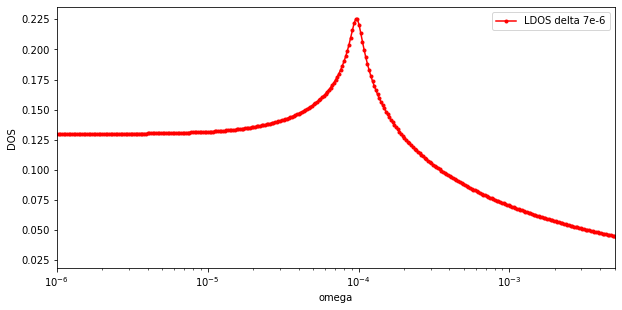

In [12]:
omegavals7e6 = np.logspace(np.log10(1e-6), np.log10(1.0e0), num = 540)
LDOS7e6 = [0.12991825733983026, 0.12991902177803855, 0.12991981472623532, 0.1299205686585711, 0.12992154127573863, 0.12992247119037376, 0.12992344775000095, 0.12992456512964828, 0.12992573685148878, 0.12992688343455644, 0.12992828475666726, 0.1299296400668037, 0.1299311816395873, 0.12993272278605847, 0.12993440753692184, 0.1299361498740171, 0.12993810158008012, 0.12994014431695822, 0.12994231586020621, 0.12994464906530162, 0.12994700639037066, 0.129949711874054, 0.12995242923206474, 0.12995528105642165, 0.12995838460956483, 0.12996158543564212, 0.1299651032863685, 0.12996873018527458, 0.12997266230048773, 0.12997678806141078, 0.12998107094017233, 0.12998580380131605, 0.12999065235411436, 0.129995818895984, 0.13000128698514524, 0.13000695284866207, 0.13001313193057965, 0.13001954678510935, 0.13002646556947667, 0.13003370395079702, 0.13004126077075184, 0.1300492603330828, 0.13005770154820717, 0.1300668413409634, 0.1300762608470211, 0.13008615656924585, 0.13009662394748517, 0.13010768641557655, 0.13011936116681633, 0.13013174200579536, 0.13014467302448632, 0.13015823756340578, 0.13017275120407582, 0.1301877918444559, 0.13020374451525515, 0.13022056976581375, 0.1302382872113909, 0.13025671234511088, 0.13027605040901888, 0.13029669171461233, 0.1303182218623431, 0.13034077595187443, 0.13036431004436305, 0.13038941208487692, 0.1304155174702244, 0.1304430679361033, 0.13047181982923975, 0.13050195088825933, 0.1305336138393707, 0.1305668329698733, 0.13060163686263998, 0.1306380456695101, 0.13067600590969403, 0.13071593232980994, 0.1307578552657649, 0.13080126176414683, 0.13084723152846872, 0.13089504427143153, 0.13094474510210483, 0.130996958616595, 0.13105157272708468, 0.13110838983527462, 0.13116770525875882, 0.13122984525333295, 0.13129442601654237, 0.13136195259383157, 0.13143230803320197, 0.13150570154745284, 0.13158209816910107, 0.13157125825042876, 0.13165476209679242, 0.1316535866791974, 0.1317441897262348, 0.13183852656660544, 0.13193655662471038, 0.13203823117150656, 0.1321444347381369, 0.13233836246137412, 0.13240248581028874, 0.13252153358971025, 0.13255698643083252, 0.13268759342799163, 0.13282289514106085, 0.13296342722390206, 0.13310912967131214, 0.13326024616124527, 0.13341711946668672, 0.13357959317408907, 0.13374815814210939, 0.13392304862684729, 0.1341043380812112, 0.13429243707138572, 0.134487428176051, 0.13468978019874744, 0.13489952952684614, 0.13511675090999337, 0.13534215593704266, 0.1355759528905749, 0.135818450784564, 0.1360700063696246, 0.13633080544213202, 0.13660126908363984, 0.13688194727522443, 0.13717325191454663, 0.13747543983158952, 0.13778870475792696, 0.13811414483224585, 0.13845196840355806, 0.13880258893991534, 0.13916643685264274, 0.1395446238314482, 0.13993735825182033, 0.14034531527301977, 0.14076940667075802, 0.14121033158392288, 0.1416688188331366, 0.14214545838262374, 0.14264177343964646, 0.14315824521913234, 0.14369605447708542, 0.14425635879861048, 0.1448404172616116, 0.14544923923719724, 0.1460847533846399, 0.146748057876808, 0.14744083990841317, 0.14816532689079712, 0.14892288172618126, 0.14971610461981688, 0.150546965629204, 0.15141847345096768, 0.15233324653440414, 0.1532943267343261, 0.1543052393154271, 0.15537007824187266, 0.15649327180126044, 0.15767932797923162, 0.15893415692233706, 0.1602638478254139, 0.16167543987581173, 0.16317748068024168, 0.16477899614745342, 0.16649106434878938, 0.16832647379748228, 0.17029976744930922, 0.17242901992043566, 0.1747350937249589, 0.1772432966240096, 0.17998396314489054, 0.18299441170156236, 0.1863187014987667, 0.1900119098355379, 0.19413723641469915, 0.1987643417035017, 0.20395311537094304, 0.2097046610799667, 0.2158204770184827, 0.22157453002521524, 0.22528971173439222, 0.22493172230911052, 0.22046755693305764, 0.2137106057881423, 0.20651367165503035, 0.19967445035391762, 0.19341946602886595, 0.18775532655378574, 0.18262199375075974, 0.1779477521553844, 0.17366638013263247, 0.16972114301966582, 0.16606508725527014, 0.16265930025142483, 0.1594720099006455, 0.15647629781820543, 0.1536502805055795, 0.15097535780017432, 0.14843546301085467, 0.1460174431475688, 0.14370964735609645, 0.14150218300531592, 0.13938620944249616, 0.1373541688853333, 0.13539951084815008, 0.13351619220620659, 0.13169909722928, 0.12994380107111939, 0.1282455466728711, 0.12660056422510158, 0.1250058442467705, 0.123458397536236, 0.12195523535825918, 0.12049389174284617, 0.11907196549387904, 0.1176873026582374, 0.11633813417566435, 0.11502247728403006, 0.11373887237716686, 0.11248558523216075, 0.11126142983253216, 0.11006450450631244, 0.10889416067129604, 0.10774927045694212, 0.10662840726203232, 0.10553081610487368, 0.10445561417507432, 0.10340165160570518, 0.10236836806727445, 0.10135480530644528, 0.10036050171926579, 0.0993844251312929, 0.09842666107882331, 0.09748500441959676, 0.09656125857422038, 0.09565179124954715, 0.0947591713227526, 0.09388052744625996, 0.09301692710877375, 0.09216716248624822, 0.09133135368447988, 0.09050887890885799, 0.08969843908436397, 0.08890108108643766, 0.08811572582654757, 0.08734229689606696, 0.08658033554043966, 0.08582927809143953, 0.08508891434212885, 0.08435929489158453, 0.0836400083435963, 0.08293070662524082, 0.08223101298886872, 0.08154150480521473, 0.0808607345574992, 0.08019014367968395, 0.07952610124269464, 0.0788725446522355, 0.07822621275270217, 0.07758960147250664, 0.0769592897244483, 0.07633795808189285, 0.07572438962001506, 0.07511798129960494, 0.07451955020264629, 0.07392783246693665, 0.0733432041782299, 0.07276556003809587, 0.0721952379665142, 0.0716308126313149, 0.07107260137852166, 0.0705223536064193, 0.0699764323169256, 0.06943766757903644, 0.06890460115360755, 0.06837824392935402, 0.06785661338782745, 0.06734094311328018, 0.06683942655846335, 0.06633458114417666, 0.06583606431436086, 0.06534169791707861, 0.06485272183243111, 0.0643691927735855, 0.06389085517380257, 0.06341701504020159, 0.06294870015430967, 0.062484437627170174, 0.06202537300671643, 0.06157121695954485, 0.0611205353063196, 0.060674842461742415, 0.060233528108970584, 0.05979622023727357, 0.05936386330577304, 0.05893594105758285, 0.058510674273511254, 0.05809035839667645, 0.057674409942051134, 0.05726247081969659, 0.056854796070870066, 0.056450923999828026, 0.0560478789591021, 0.05565131635542448, 0.055259591236993845, 0.054868742588940325, 0.054481476388313715, 0.05409931134836546, 0.053720225069153596, 0.05334409996107698, 0.05297223018033191, 0.05260477897533453, 0.05223768377659415, 0.05187601008003169, 0.05151598774260413, 0.05116033982315827, 0.05080806627575551, 0.05045805339316661, 0.05011107270825873, 0.04976910687584125, 0.049426919670258175, 0.049090967340691814, 0.0487579383600011, 0.04842486238421746, 0.04809698477005206, 0.047771241323877583, 0.04744708635035813, 0.04712744080997387, 0.046809726702953386, 0.046495165090238245, 0.046184017417046135, 0.045873575477401396, 0.04556719712378412, 0.04526392695676583, 0.0449648214199724, 0.04466561029405796, 0.04436977010109237, 0.044076982899046394, 0.04378577331613891, 0.0434988154917501, 0.04321548100850987, 0.04293070336720096, 0.04265284752311749, 0.042373314226961285, 0.042100226516851004, 0.04182674761705249, 0.0415562401820322, 0.041288028123624206, 0.041023811709425546, 0.040760557352774, 0.04050083133639433, 0.04024357539331206, 0.03998779206431629, 0.03973661168853534, 0.03948648135724506, 0.03923869105580452, 0.03899238419143674, 0.038751807340904616, 0.038509916846625816, 0.03827182039542467, 0.038038482819717105, 0.03780472341421024, 0.03757451052007188, 0.03734802687107502, 0.03712409312778309, 0.036898047691761915, 0.036681904060873134, 0.03646337093577637, 0.03624505872722757, 0.03603110400323736, 0.03582291563852975, 0.035614888847026425, 0.03541155592537596, 0.035205252000736674, 0.035007046265887465, 0.034812216509833946, 0.03461674872777122, 0.034420933734519765, 0.03422942535314867, 0.03404742421570171, 0.033859473200046016, 0.03367761838669366, 0.033497713741527664, 0.03332033455225142, 0.033147175475156436, 0.03297832552496548, 0.032814565245220854, 0.03264416552360093, 0.0324833298090502, 0.032320616678099996, 0.03216804806842703, 0.03201362128569348, 0.031856357979692454, 0.031707145171652906, 0.03156314551998707, 0.03142077183416977, 0.03127946194548425, 0.03114379513226991, 0.031008990628192887, 0.03088106260390367, 0.030748048047427777, 0.030627750833715668, 0.030505073831067424, 0.03038306160817387, 0.030271406996056426, 0.030164507712720084, 0.030044762497684396, 0.029944091930451486, 0.029845361780569332, 0.02974236875608014, 0.029649718770741445, 0.029547891473382448, 0.029460704419995314, 0.029378541711178638, 0.02929505770672997, 0.029214459114932576, 0.029136920207504628, 0.02906639852692988, 0.028993952021367547, 0.0289255194739732, 0.02886504974970341, 0.02880492344975111, 0.028750456403233583, 0.028702772327132073, 0.02866387584218222, 0.028611247222341853, 0.028571427643206648, 0.028542169008049255, 0.028512686378318455, 0.028477702192333584, 0.028459630892085593, 0.02843473134234329, 0.028424990612019373, 0.028408505409477713, 0.028400160708180723, 0.028399282833264265, 0.02840455440331692, 0.028402633591392605, 0.028412808653651766, 0.028429986310864436, 0.028442127857779855, 0.028473109700676603, 0.028497619546646338, 0.028538529237113055, 0.028574440151842663, 0.028616212384849852, 0.028652180821288214, 0.02871023058016626, 0.028769098999655032, 0.028820775238222688, 0.02889965703486664, 0.028963116214467254, 0.029041976011154887, 0.02912365098474374, 0.029215370441244684, 0.029309563839883587, 0.029410011373230963, 0.02950610278105127, 0.029621190196163372, 0.02974740074671822, 0.029858062100191558, 0.02999439772966657, 0.030124566628459533, 0.03026737205541319, 0.03041594923481275, 0.03057222232340511, 0.030727150262973735, 0.03089027426954794, 0.03106981832945851, 0.031242501200859408, 0.031443256026373496, 0.03163091458779424, 0.03183915718627185, 0.03203732579629103, 0.03225682008275824, 0.032483916324122085, 0.03272278172618719, 0.03296826214320553, 0.03320478096626275, 0.03347758111630585, 0.033747992713123, 0.03402190206316536, 0.03429523122666738, 0.03459121375375643, 0.034900314977850115, 0.03520862351470786, 0.03553412433270638, 0.03586597030981341, 0.036218879704542684, 0.03656478812838505, 0.03692406716400713, 0.03730819160228017, 0.037689176868566716, 0.038102114462553294, 0.038505472168430185, 0.03893540549796976, 0.03935699847620882, 0.03981292988336444, 0.040267972909960564, 0.04075297102707876, 0.041233672199969575, 0.041744216826198326, 0.04226178114109677, 0.04279790365639713, 0.043342028488644345, 0.04389445588706966, 0.04589394760267808, 0.04713247232757727, 0.04843420889588001, 0.04974644855854379, 0.051095696867266394, 0.052489696345714223, 0.05391380787311163, 0.05539618935309536, 0.05690307967061395, 0.058453816809292784, 0.06004574067393149, 0.06167291635345747, 0.06336440881227906, 0.06509761838297273, 0.06688360458927475, 0.06870805503177532, 0.07056988550498978, 0.07250814291594566, 0.07450936126285229, 0.07654545201216045, 0.07864684719258967, 0.08079897298487847, 0.08300463293422064, 0.08528759502074183, 0.08765711064078567, 0.09008051964794422, 0.09258363744338029, 0.09515862296390606, 0.09779341259068054, 0.10052477583977047, 0.1033136489288139, 0.10620278602454523, 0.10917736628012954, 0.11225912208058857, 0.11541956527595525, 0.11869763083858642]
fig,ax = plt.subplots(1, figsize=(10, 4.8))
#ax.plot(omegavals, LDOS5, '.-', label = 'LDOS delta 1e-5')
#ax.plot(omegavals, LDOS4, '.-', label = 'LDOS delta 1e-4')
#ax.plot(omegavals, LDOS3, '.-', label = 'LDOS delta 1e-3')

ax.plot(omegavals7e6, LDOS7e6, '.-', color='red', label = 'LDOS delta 7e-6')
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(1e-6, 0.005)
ax.set_ylabel('DOS')
ax.set_xscale('log')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

### Running scripts

In [10]:
#this is for delta'=gamma4=0
!python run_integration_7e6.py

1.68837071695505e-05 0.1341541207079216
1.722072780170975e-05 0.13429996180477313
1.7564475801582727e-05 0.13444984854727998
1.7915085456130074e-05 0.13460408362871742
1.827269373285386e-05 0.13476269521457196
1.863744033330453e-05 0.13492571127439112
1.9009467747656282e-05 0.13509349460376568
1.9388921310371477e-05 0.13526585156146329
1.977594925697621e-05 0.13544310550165672
2.017070278196951e-05 0.13562560456357364
2.0573336097888166e-05 0.13581319729133026
2.0984006495550538e-05 0.13600621245993227
2.1402874405503268e-05 0.1362046262570582
0.0007966866754097959 0.0753400475279229
0.0008125895718698626 0.07487539163958132
0.0008288099107117652 0.07441555374388874
0.0008453540284960204 0.0739593842856334
0.0008622283882690853 0.07350818762583426
0.0008794395820881867 0.07306039240035467
0.0008969943335965371 0.07261692983081253
0.0009148995006499638 0.07217825049740882
0.000933162077995969 0.071742031968718
0.0009517892000062582 0.07131087287041597
0.0009707881434638271 0.07088261026

### Plotting data from files and saving to csv

#### Precision 7e-6 stable 540 points

In [4]:
f = open('DOS_data_file_BLG_7em6_deltap_gamma4_zero.txt', 'rb')
omegavals = pickle.load(f)
arr = pickle.load(f)
f.close()

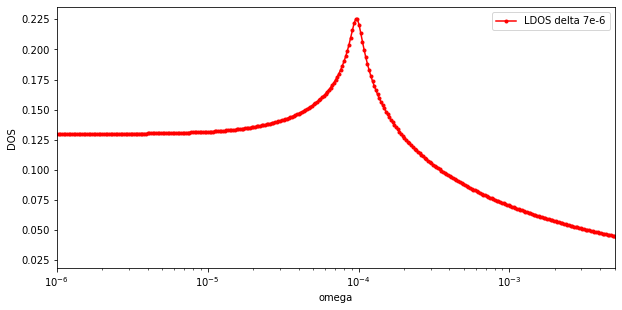

In [5]:
fig,ax = plt.subplots(1, figsize=(10, 4.8))
ax.plot(omegavals, arr, '.-', color='red', label = 'LDOS delta 7e-6')
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(1e-6, 0.005)
ax.set_ylabel('DOS')
ax.set_xscale('log')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

In [9]:
np.savetxt("DOS_data_BLG_7em6_deltap_gamma4_zero_freq.csv", omegavals, delimiter=",")

In [8]:
np.savetxt("DOS_data_BLG_7em6_deltap_gamma4_zero.csv", arr, delimiter=",")

#### the same, but 700 points and adjusted precision
1e-5 if omega>1e-3 else 7e-6

In [11]:
f = open('DOS_data_file_BLG_delta_gamma4_zero_700points.txt', 'rb')
omegavals = pickle.load(f)
arr = pickle.load(f)
f.close()

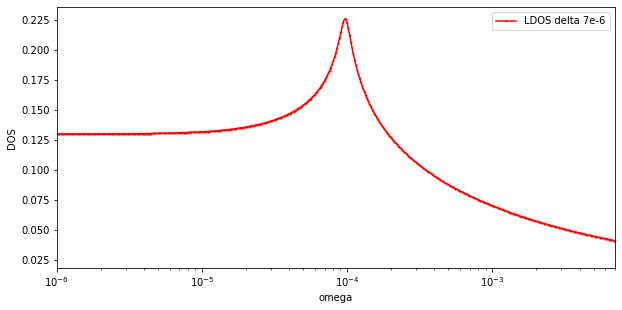

In [16]:
fig,ax = plt.subplots(1, figsize=(10, 4.8))
ax.plot(omegavals, arr, '.-', color='red', label = 'LDOS delta 7e-6', markersize=2.0)
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(1e-6, 0.007)
ax.set_ylabel('DOS')
ax.set_xscale('log')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

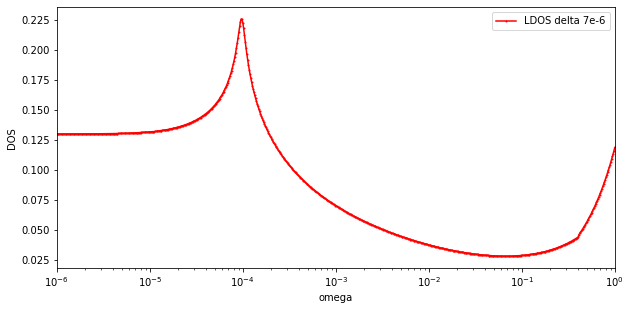

In [20]:
fig,ax = plt.subplots(1, figsize=(10, 4.8))
ax.plot(omegavals, arr, '.-', color='red', label = 'LDOS delta 7e-6', markersize=2.0)
#ax.axvline(1., ls='--', c='grey')
ax.set_xlabel('omega')
ax.set_xlim(1e-6, 1.)
ax.set_ylabel('DOS')
ax.set_xscale('log')
plt.legend()
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

In [17]:
np.savetxt("DOS_data_BLG_deltap_gamma4_zero_700point_freq.csv", omegavals, delimiter=",")

In [18]:
np.savetxt("DOS_data_BLG_deltap_gamma4_zero_700point.csv", arr, delimiter=",")